In [2]:
import numpy as np
import pandas as pd
import base64
import pickle

from sklearn import linear_model, datasets, utils, feature_extraction, preprocessing
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from sklearn.externals import joblib

from IPython.display import IFrame
from IPython.core.display import display

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

import user_functions

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Somers' D Related Python Functions

def somersd(score, target, bins=500):
    pred = np.array([score, target]).T
    score, target = pred[pred.argsort(0)[:, 0]].T

    n_1=float(sum(target))
    n_0=float(len(score)-n_1)

    pct_1=[0.0]
    pct_0=[0.0]

    for i in xrange(bins):
        end = int(float(i+1)/bins*len(pred))
        c_1 = sum(target[0:end])
        pct_1.append(c_1/n_1)
        pct_0.append((end-c_1)/n_0)

    pct_1.append(1.0)
    pct_0.append(1.0)

    sd=[(pct_1[i+1]+pct_1[i])*(pct_0[i+1]-pct_0[i]) for i in xrange(bins)]

    somersd=1-sum(sd)
    return somersd

def somers_plots(preds, bins=40):
    figsize(16,8)
    df = pd.DataFrame()
    # Python 3 uses .items() instead of .iteritems()
    for model, pred in preds.iteritems():
        mname = str(model)[:str(model).find("(")]
        p = pred[pred.argsort(0)[:,0]]
        pct = []
        for i in xrange(bins):
            start = int(float(i)/bins*len(p))
            end = int(float(i+1)/bins*len(p))
            pct.append((i, np.mean(p[start:end,1])))
        pct = np.array(pct)
        # Python 3 uses print()
        print pct
        som = '(%.3f)' % somersd(p[:,0], p[:,1])
        df = pd.concat([df, pd.DataFrame([pct, mname+som, som]).T])

    for k, v in df.sort(2, ascending=False).iterrows():
        pct = v.get_values()[0]
        plot(pct[:,0], pct[:,1], label=v[1])

    # ylim(0,0.8)
    legend(loc='lower right')
    show()
    

In [29]:
train = pd.io.parsers.read_csv('buildRHC.csv', sep=',', index_col=None, header=0)
test = pd.io.parsers.read_csv('validRHC.csv', sep=',', index_col=None, header=0)
id = pd.io.parsers.read_csv('id.csv', sep=',', index_col=None, header=0)

In [5]:
train.shape

(891, 9)

In [6]:
test.shape

(418, 8)

In [7]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_Q,Embarked_S
0,0,3,39.0,1,5,31.2750,1.0,0.0,1.0
1,0,1,0.0,0,0,39.6000,0.0,0.0,0.0
2,0,3,44.0,0,1,16.1000,0.0,0.0,1.0
3,0,3,15.0,1,1,7.2292,0.0,0.0,0.0
4,0,1,0.0,0,0,31.0000,0.0,0.0,1.0


In [8]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,1.0


### PREP 

In [9]:
xTrain = train.ix[:, 1:]
xTest = test.ix[:,:]

In [10]:
xTrain.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_Q,Embarked_S
0,3,39.0,1,5,31.2750,1.0,0.0,1.0
1,1,0.0,0,0,39.6000,0.0,0.0,0.0
2,3,44.0,0,1,16.1000,0.0,0.0,1.0
3,3,15.0,1,1,7.2292,0.0,0.0,0.0
4,1,0.0,0,0,31.0000,0.0,0.0,1.0


In [11]:
xTest.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,1.0


In [15]:
yTrain=pd.DataFrame()
yTrain['Survived']=train.ix[:,0]
yTrain.head()

,Survived
0,0
1,0
2,0
3,0
4,0


In [13]:
yTrain['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [14]:
cols=xTrain.ix[:,:].columns

predictorsTrain = xTrain.values
predictorsTest = xTest.values

targetTrain = yTrain.Survived.values

### Gradient Boosting 

In [16]:
preds = {}

gbaModel = GradientBoostingClassifier()
gbaModel.fit(predictorsTrain, targetTrain)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

/Users/zhou/Applications/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/zhou/Applications/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[[  0.           0.        ]
 [  1.           0.        ]
 [  2.           0.        ]
 [  3.           0.        ]
 [  4.           0.        ]
 [  5.           0.04545455]
 [  6.           0.        ]
 [  7.           0.08695652]
 [  8.           0.04545455]
 [  9.           0.04545455]
 [ 10.           0.08695652]
 [ 11.           0.09090909]
 [ 12.           0.04545455]
 [ 13.           0.09090909]
 [ 14.           0.17391304]
 [ 15.           0.04545455]
 [ 16.           0.09090909]
 [ 17.           0.04545455]
 [ 18.           0.13043478]
 [ 19.           0.18181818]
 [ 20.           0.18181818]
 [ 21.           0.13043478]
 [ 22.           0.13636364]
 [ 23.           0.31818182]
 [ 24.           0.40909091]
 [ 25.           0.56521739]
 [ 26.           0.45454545]
 [ 27.           0.68181818]
 [ 28.           0.72727273]
 [ 29.           0.82608696]
 [ 30.           0.90909091]
 [ 31.           0.95454545]
 [ 32.           0.91304348]
 [ 33.           0.95454545]
 [ 34.        

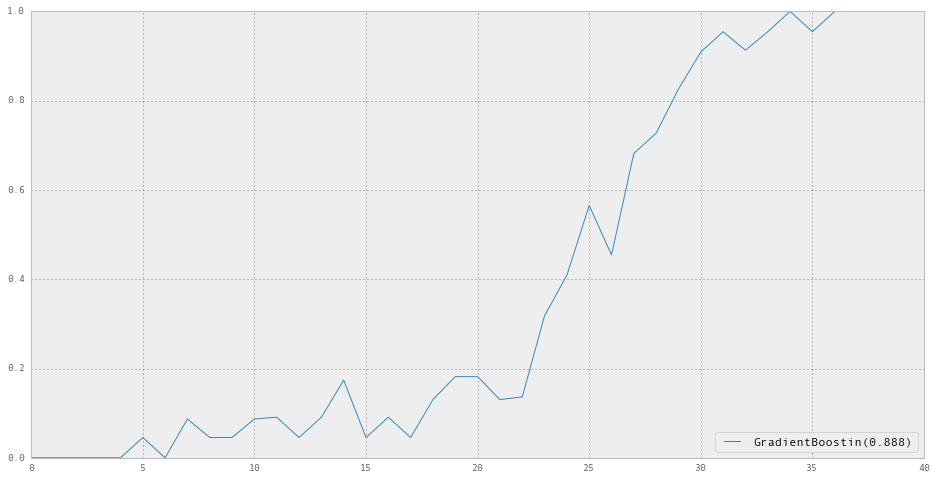

In [17]:
# Performance on Train

preds["GradientBoosting"] = np.array(zip(gbaModel.predict_proba(predictorsTrain)[:,1], targetTrain))

pd.options.display.mpl_style = 'default'

somers_plots(preds,bins=40)

In [18]:
indices = np.argsort(gbaModel.feature_importances_)[::-1]

print "Feature ranking:"
for f in xrange(8):
    print cols[indices[f]], "\t", indices[f], "\t", gbaModel.feature_importances_[indices[f]]

Feature ranking:
Age 	1 	0.372253354564
Fare 	4 	0.338408766032
Sex_female 	5 	0.144310229475
Pclass 	0 	0.0541197622352
SibSp 	2 	0.0430774734618
Parch 	3 	0.0272725974186
Embarked_S 	7 	0.0151142011776
Embarked_Q 	6 	0.00544361563542


________________________________________________________________________________


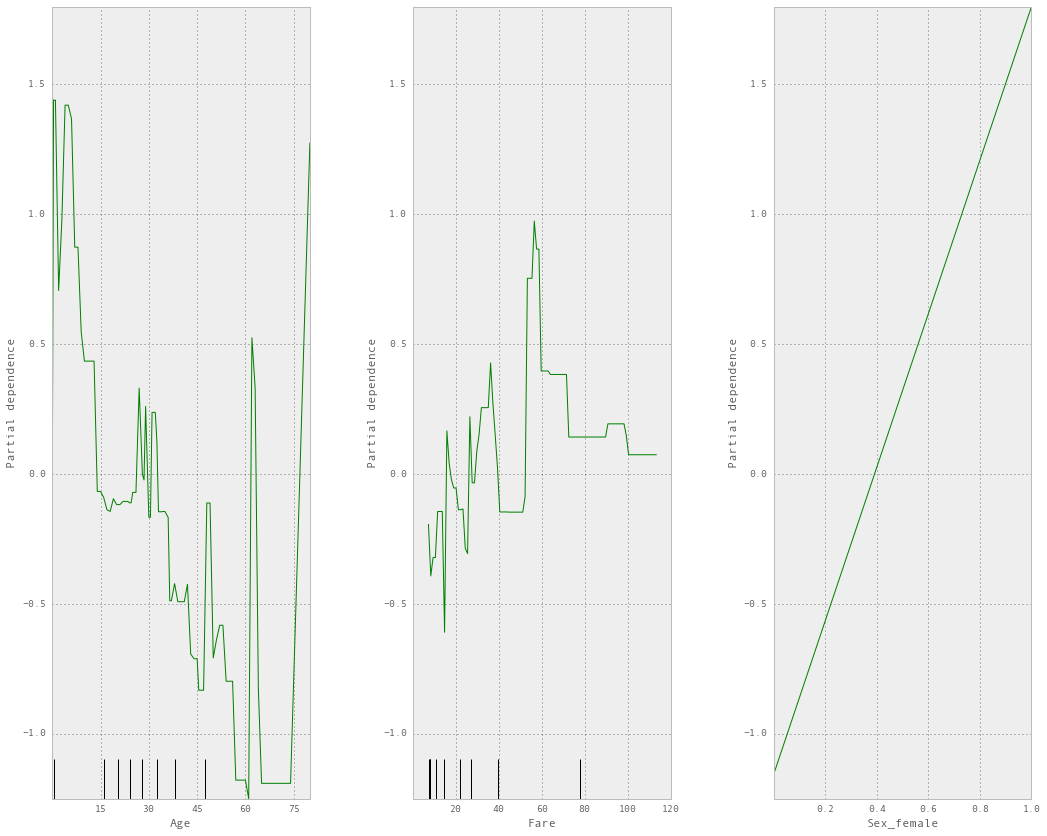

In [19]:
figsize(16,20)
features = [1,4,5]
fig, axs = plot_partial_dependence(gbaModel, predictorsTrain, features, feature_names=cols, n_jobs=3, grid_resolution=100)
plt.subplots_adjust(hspace=0.5)
print('_' * 80)
fig = plt.figure()
pd.options.display.mpl_style = 'default'
plt.show()

### Write to output

In [21]:
predictions = gbaModel.predict_proba(predictorsTest)[:,1]

In [22]:
predictions_lst = []
for i in predictions:
    if i > 0.5:
        predictions_lst.append(1)
    else:
        predictions_lst.append(0)

In [24]:
len(predictions_lst)

418

In [31]:
id.shape

(418, 1)

In [32]:
predictions_df=pd.DataFrame(predictions_lst,columns=['Survived'])

In [33]:
predictions_df.shape

(418, 1)

In [34]:
result = pd.concat([id, predictions_df], axis=1)

In [35]:
result.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [36]:
result.to_csv("advancedgbmmodel.csv", sep=',', index=False)